<a href="https://colab.research.google.com/github/KhondamirRustamov/FoldCraft/blob/main/FoldCraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title setup
%%time
import os

if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")
os.system('pip -q install mdanalysis')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

CPU times: user 1.89 s, sys: 352 ms, total: 2.24 s
Wall time: 2min 33s


CMAP of 1QYS (monomer plddt: 0.914)
Target (blue)
Binder (red)


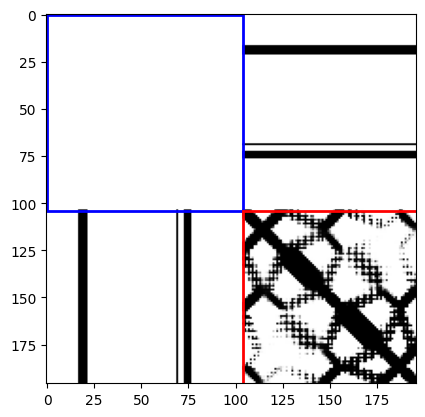

In [8]:
#@title Prepare fold conditioned binder | Construct target cmap for binder-target complex
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
#@markdown Prepare fold conditioned binder
binder_template = '1QYS' #@param {type:"string"}
chain_template = 'A' #@param {type:"string"}
hotspots = ''
template_pdb = get_pdb(binder_template)

pdbparser = PDBParser()

structure = pdbparser.get_structure(binder_template, template_pdb)
chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()}

query_chain = chains[chain_template]

af_model = mk_afdesign_model(protocol="fixbb", use_templates=True)
af_model.prep_inputs(pdb_filename=template_pdb,
                     ignore_missing=False,
                     chain = chain_template,
                     rm_template_seq=False,
                     rm_template_sc=False,)

#name='9had'
af_model.set_seq(query_chain[:af_model._len])
af_model.predict(num_recycles=3, verbose=False)
print(f"CMAP of {binder_template} (monomer plddt: {af_model.aux['log']['plddt']:.3f})")
#plt.imshow(af_model.aux['cmap'])

import matplotlib.pyplot as plt
import MDAnalysis as mda

import warnings
warnings.filterwarnings("ignore")
#@markdown Prepare target protein structure
pdb_target = 'Q9NZQ7' #@param {type:"string"}
#@markdown Select chain for target protein. If you want to **trim** the protein use **":"** after the chain id and write the **start-end** of trimming region using "-"
chain_id = 'A:19-132' #@param {type:"string"}

pdb_target_path = get_pdb(pdb_target)

def set_range(hotspots_input):
  new_h = [x for x in hotspots_input.split(',')]
  h_range = []
  for i in new_h:
    if '-' in i:
      h_range += [x for x in range(int(i.split('-')[0]), int(i.split('-')[1]))]
    else:
      h_range.append(int(i))
  return h_range

#@markdown Choose hotspots on target protein
target_hotspots = '36-41,88,92-96' #@param {type:"string"}
#@markdown Optional: Choose hotspots on binder protein
binder_hotspots = '' #@param {type:"string"}

if ':' in chain_id:
  chain_cut = [int(x) for x in chain_id.split(':')[-1].split('-')]
  chain_id = chain_id.split(':')[0]
  uref = mda.Universe(f'AF-{pdb_target}-F1-model_v3.pdb')
  uref = uref.select_atoms(f'resid {chain_cut[0]}:{chain_cut[1]}')
  uref.write(f"AF-{pdb_target}-F1-model_v3.pdb")
  target_hotspots_np = np.array(set_range(target_hotspots))-chain_cut[0]
else:
  target_hotspots_np = np.array(set_range(target_hotspots))

af_target = mk_afdesign_model(protocol="fixbb", use_templates=True)
af_target.prep_inputs(pdb_filename=pdb_target_path,
                     ignore_missing=False,
                     chain = chain_id,)

target_len = af_target._len
binder_len = af_model._len

load_np = af_model.aux['cmap']

fc_cmap = np.zeros((target_len+binder_len, target_len+binder_len))

if binder_hotspots == '':
  cdr_range = np.array([range(0,binder_len)])+target_len
else:
  cdr_range = np.array(set_range(binder_hotspots))+target_len

fc_cmap[-binder_len:,-binder_len:] = load_np


for i in target_hotspots_np:
    for x in cdr_range:
        fc_cmap[x,i] = 1.
        fc_cmap[i,x] = 1.

from matplotlib import patches
fig, ax = plt.subplots()
plt.imshow(fc_cmap,cmap='grey_r')
rect = patches.Rectangle((0, 0), target_len, target_len, linewidth=2, edgecolor='b', facecolor='none')
rect2 = patches.Rectangle((target_len, target_len), binder_len, binder_len, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)
print('Target (blue)')
print('Binder (red)')
np.save('fold_cond_cmap.npy',fc_cmap)

fc_cmap[fc_cmap>0] = 1
np.save('fold_cond_cmap_mask.npy',fc_cmap)

In [ ]:
#@title Define fold-conditioned loss and run 3stage design (100,100,20)
from colabdesign.af.loss import get_contact_map
import jax
import jax.numpy as jnp

conditioned_array = np.load('fold_cond_cmap.npy')
conditioned_mask = np.load('fold_cond_cmap_mask.npy')

def cmap_loss_binder(inputs, outputs):
    global conditioned_array
    global conditioned_mask
    global binder_len

    i_cmap = get_contact_map(outputs, inputs["opt"]["i_con"]["cutoff"])
    cmap = get_contact_map(outputs, inputs["opt"]["con"]["cutoff"])
    i_cmap = i_cmap.at[-binder_len:,-binder_len:].set(cmap[-binder_len:,-binder_len:])
    out_cmap_conditioned = i_cmap * conditioned_mask
    cmap_loss_binder = jnp.sqrt(jnp.square(out_cmap_conditioned - conditioned_array).sum(-1).mean())

    return {"cmap_loss_binder":cmap_loss_binder}

name = 'tmp_0' #@param {type:"string"}
rm_aa = 'C' #@param {type:"string"}

af_model_design = mk_afdesign_model(protocol="binder", loss_callback=cmap_loss_binder,
                                     use_templates=True,)

af_model_design.prep_inputs(pdb_filename=pdb_target_path,
                             chain=chain_id, binder_len = binder_len,
                             hotspot=target_hotspots,
                             rm_aa=rm_aa, #fix_pos=fixed_positions,
                             )

af_model_design.opt["weights"]["cmap_loss_binder"] = 1.
af_model_design.opt["weights"].update({"cmap_loss_binder":1.0, "rmsd":0.0, "fape":0.0, "plddt":0.0,
                                        "con":0.0, "i_con":0.0, "i_pae":0.})

af_model_design.design_3stage(100,100,20)

Stage 1: running (logits → soft)
1 models [0] recycles 0 hard 0 soft 0.01 temp 1 loss 4.40 plddt 0.62 ptm 0.51 i_ptm 0.10 cmap_loss_binder 4.40
2 models [0] recycles 0 hard 0 soft 0.02 temp 1 loss 4.47 plddt 0.93 ptm 0.49 i_ptm 0.06 cmap_loss_binder 4.47
3 models [0] recycles 0 hard 0 soft 0.03 temp 1 loss 4.43 plddt 0.86 ptm 0.50 i_ptm 0.09 cmap_loss_binder 4.43
4 models [0] recycles 0 hard 0 soft 0.04 temp 1 loss 4.40 plddt 0.70 ptm 0.51 i_ptm 0.09 cmap_loss_binder 4.40
5 models [1] recycles 0 hard 0 soft 0.05 temp 1 loss 4.38 plddt 0.71 ptm 0.50 i_ptm 0.06 cmap_loss_binder 4.38
6 models [1] recycles 0 hard 0 soft 0.06 temp 1 loss 4.40 plddt 0.58 ptm 0.51 i_ptm 0.07 cmap_loss_binder 4.40
7 models [0] recycles 0 hard 0 soft 0.07 temp 1 loss 4.39 plddt 0.81 ptm 0.51 i_ptm 0.08 cmap_loss_binder 4.39
8 models [0] recycles 0 hard 0 soft 0.08 temp 1 loss 4.36 plddt 0.67 ptm 0.50 i_ptm 0.08 cmap_loss_binder 4.36
9 models [0] recycles 0 hard 0 soft 0.09 temp 1 loss 4.36 plddt 0.72 ptm 0.50 i